# 08 Instrumental Variables

In [31]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS


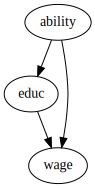

In [8]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

- 위의 경우에는 `ability`를 regression model의 변수로 넣어서 confounder의 영향을 없애면 된다.
- 하지만 그게 어려운 경우도 존재한다. (ability를 어떻게 측정?, unobserved confounder 등등)
- 이럴 때, IV를 사용할 수 있다.

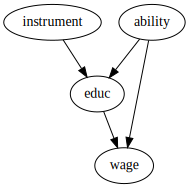

In [9]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

- IV은 오직 treatment를 cause하고 오직 treatment를 통해서만 outcome과 correlated되어 있다.
- $Z$: IV, $T$: treatment, $W$: confounder 라고 하자. 하지만 $W$는 현재 모르는 상황인 것이다. 그래서 IV을 이용하여 causality를 구하면:

$$Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i$$

$$Cov(Z, Y) = Cov(Z, \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i) \\ = \kappa Cov(Z,T)$$

$$\kappa = \dfrac{Cov(Y_i, Z_i)}{Cov(T_i, Z_i)}$$

$$\therefore \kappa = \dfrac{Cov(Y_i, Z_i)/V(Z_i)}{Cov(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form (2nd Stage)}}{\text{1st Stage}}$$

- 분모, 분자 모두 regression coefficient이다.
- 만약에 IV가 binary이면 아래의 식이고 Wald Estimator라고 부른다.

$$\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}$$





## Quarter of Birth and the Effect of Education on Wage

- 실제 데이터를 통해 이해해보자.
- 미국에서는 1월 1일 기준으로 6살인 아이가 학교에 입학한다. 그리고 16살이 되면 의무교육이 끝난다고 한다. 따라서 1년을 기준으로 늦게 태어날수록 (q4에 태어날수록) 교육을 받는 기간이 길다.

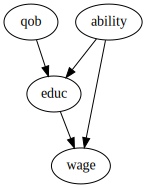

In [2]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

In [4]:
data = pd.read_csv("../data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


- 먼저 1st stage의 값을 구해보자. 그전에 앞서 instrumental variable이 되기 위한 조건은
  1. $Cov(Z,T) \neq 0$
  2. $Y \perp Z | T$
- 위의 조건을 만족하는지 확인하고 instrumental variable을 이용할 수 있을 것이다.
- 첫번째 조건은 1st stage로 값을 구하면 알 수 있고 두번째 조건은 확인하기 어렵다.
- 이 값을 구하기 위해 linear regression을 이용하자.

In [5]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth,q1,q2,q3,q4
0,5.790019,12.0,30.0,1.0,45.0,1,0,0,0
1,5.952494,11.0,30.0,1.0,45.0,1,0,0,0
2,5.315949,12.0,30.0,1.0,45.0,1,0,0,0
3,5.595926,12.0,30.0,1.0,45.0,1,0,0,0
4,6.068915,12.0,30.0,1.0,37.0,1,0,0,0


In [7]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate: ", first_stage.params["q4"])
print("q4 p-value: ", first_stage.pvalues["q4"])

q4 parameter estimate:  0.10085809272786944
q4 p-value:  5.464829416604805e-15


- 예상대로 `q4`의 경우 유의미한 계수가 나왔고 `q4`의 경우가 그렇지 않은 경우에 비해 0.1정도 교육을 더 받았다는 것을 알 수 있다. 이는 조건1을 만족하면서 분모의 값을 구할 수 있게 된 것이다.
- 이제 Reduced Form을 구해보자. 분자의 값을 구해보자.

In [9]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate: ", reduced_form.params["q4"])
print("q4 p-value: ", reduced_form.pvalues["q4"])

q4 parameter estimate:  0.008603484260142624
q4 p-value:  0.0014949127183610013


- 유의미한 값이 나왔다.
- 이제 이 값들을 이용해서 ATE를 구하면 아래의 값이 나오고 우리는 교육을 더 받으면 그렇지 않은 사람에 비해 8%정도 wage가 올랐다는 것을 알 수 있다.

In [10]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492087591

- 이제 한번에 이 값을 구할 수 있는 방법에 대해 알아보자: **2SLS** (2 stages least squares)
  - 실제로 IV를 직접 구할 때, SE를 구하기도 어렵고 second stage에서 그 수치가 다소 잘못나오기 때문에 직접하기보다 아래 `linearmodels` 라이브러리를 사용하기 추천
- 이는 1st stage의 경우는 이전과 동일하게 진행하고 second stage에서 treatment variable을 1st stage에서 fitted value로 대체해서 진행한다.

$$educ_i = \gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i$$

$$log(wage)_i = \beta_0 + \beta_1 educ_i + \beta_2 yob_i + \beta_3 sob_i + u_i$$

$$log(wage)_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i ]  + \beta_2 yob_i + \beta_3 sob_i + u_i$$

- 그리고 주의할 점은 second stage에서 control하는 변수들은 first stage에서도 control해야한다.

In [11]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286492094552

- `linearmodels` 라이브러리를 이용해보자.
- first stage 부분은 `[]` 안에 넣어야 한다.
  - `[years_of_schooling ~ q4]`
- 나머지 control할 변수들은 `[]`에 넣을 필요 없이 second stage에 넣기만 하면 알아서 적용하여 계산해준다.
- 따라서 최종 `fomula`는 아래와 같이 작성하면 된다.
- `formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'`

In [12]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")


In [13]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286491441075
SE: 0.02554081281675699
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914679997937


## Multiple Instruments

- 2SLS을 이용하면 쉽게 여러개의 IV를 추가할 수 있다.
- 하지만 항상 이점만 있는 것은 아니다.

In [14]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.1076937048601394
SE: 0.019557149008834943
95 CI: [0.06936169 0.14602572]
P-value: 3.657974700921329e-08


## Weakness of Instruments

- IV방법론은 ATE를 indirectly 구하는 방법이다.
- 그래서 IV와 treatment간의 상관관계가 약한 경우 문제가 발생한다.
- simulation을 통해서 알아보자.
- True ATE는 2.0이다.

$$X \sim N(0, 2^2)\\
U \sim N(0, 2^2)\\
T \sim N(1+0.5U, 5^2)\\
Y \sim N(2+ X - 0.5U + 2T, 5^2)\\
Z \sim N(T, \sigma^2) \text{ for }\sigma^2 \text{ in 0.1 to 100}$$


In [15]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,Y,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,...,Z_40,Z_41,Z_42,Z_43,Z_44,Z_45,Z_46,Z_47,Z_48,Z_49
0,2.696148,8.056988,18.388910,8.233315,9.028779,16.430365,7.348864,4.848165,1.567900,16.654138,...,50.836515,-121.965878,-9.118833,-42.297891,17.015717,51.777219,78.678074,-164.581598,-117.798705,-13.485292
1,2.570240,0.245067,2.015052,0.455988,-0.901285,-6.442245,-2.824902,7.327944,-9.643833,14.237652,...,29.966537,141.855092,79.040440,66.249629,-23.107153,25.007034,-73.621303,85.867339,-209.727577,-70.792948
2,0.664741,5.597510,11.939170,5.528384,6.148148,10.141348,18.923875,-5.550785,4.495364,-14.070897,...,-29.051441,14.537511,-95.846490,-117.922132,43.194916,58.534855,119.820024,-173.513340,60.562232,47.619414
3,1.037725,0.493532,-5.077869,0.382075,0.790127,-2.753808,3.146698,-7.152174,-6.322238,9.209916,...,-61.446478,26.719702,-40.753912,63.725307,22.462409,97.200099,-116.309759,-26.328707,78.136513,-108.322304
4,-2.590591,-6.263014,-6.460508,-6.197533,-5.954731,-19.295207,-11.343303,-7.231806,5.556399,-17.913401,...,-28.071993,146.111732,-21.991256,88.258432,62.211154,-72.066362,51.848504,-117.858043,78.776566,-80.547214


In [16]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

- `Z_i`와 `T`는 `i`가 커질수록 상관관계가 약해진다.
- `Z_i`들을 순서대로 IV로 이용해서 추정치 ATE SE와 추정치 ATE의 변화를 살펴보자.

In [17]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

In [20]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

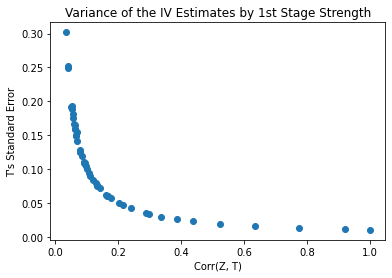

In [30]:
plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("T's Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

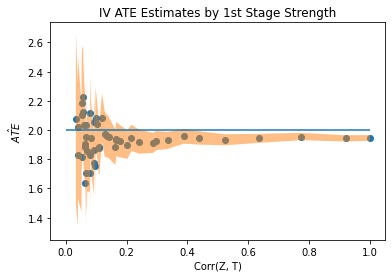

In [29]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$")
plt.hlines(2, xmin=0, xmax=1)
plt.title("IV ATE Estimates by 1st Stage Strength");

- 상관관계가 약해질수록 $\hat{ATE}$의 SE가 커지고 따라서 CI도 커지는 것을 파악할 수 있다. 
- 또한, 2SLS로 구한 ATE가 consistent하지만 biased됨을 알 수 있다. 심지어 CI이 true ATE인 2를 포함하지도 않는다!!
  - 2SLS is biased towards OLS.
  - IV를 추가할 수록 bias심해진다고 한다.

- common mistakes when doing IV
  - Doing IV by hand
  - Using anything other than OLS on the 1st stage